In [53]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pickle
import urllib
from multiprocessing import Pool, cpu_count
from itertools import repeat as irepeat
from time import time as pytime

from scipy.optimize import minimize as sci_minimize
from scipy.optimize import basinhopping
from scipy.integrate import quad
from scipy import interpolate
from scipy.io import loadmat
from scipy.stats import circmean, circstd, spearmanr, pearsonr
from scipy.signal import hilbert, convolve

!pip install brian2hears
from brian2 import *
from brian2hears import *

In [55]:
import numpy as np
from scipy.stats import spearmanr
from scipy.optimize import minimize as sci_minimize
from scipy.integrate import quad

# Tunning Curve para o IPD de theta condicionada a phi do neuronio
def g(theta : float, phi_i : float, r_max : float = 1) -> float:
  return r_max * (np.cos((theta - phi_i)/2) + 0.5)**4

# Funcao da informacao de Fisher de um neuronio
# Seu valor de phi eh parametrizado
def fi(phi : np.ndarray, T : float = 1, r_max : float = 1) -> list:
  fs = []
  for phi_i in phi:
    intermediate = lambda p_i : lambda theta : T*r_max*((np.cos(theta - p_i) + 1)**2)*np.sin(theta - p_i)**2
    fs.append(intermediate(phi_i))

  return fs

# Funcao de 1 sobre a Funcao da informacao de Fisher da populacao
# Eh obtida pela soma das funcoes de informacao de fisher para cada valor de phi
def F(theta : float, phi : np.ndarray, T : float = 1, r_max : float = 1) -> float:
  fs = fi(phi, T, r_max)
  return 1/np.sum([f(theta) for f in fs])

# Funcao custo em funcao dos parametros phi da populacao
# obtida pela integracao de 1/F, em que F eh a informacao de Fisher da populacao
# os limites de integracao delimitam o theta
def V(phi : np.ndarray, lim : float, T : float = 1, r_max : float = 1) -> float:
  return quad(F, -lim, lim, args=(phi, T, r_max))[0]

def optimize(lim, phi_rand):
  res = sci_minimize(V, phi_rand, (lim, 1, 1), method='Powell')
  if res.success:
    return res.x
  else:
    return [None for phi in phi_rand]

def f_neural(theta : float, phi : np.ndarray, T : float = 1, r_max : float = 1) -> float:
  fs = fi(phi, T, r_max)
  return np.sum([f(theta) for f in fs])

def F_neural(theta : np.ndarray, phi : np.ndarray, T : float = 1, r_max : float = 1) -> np.ndarray:
  return np.array([f_neural(th, phi, T, r_max) for th in theta])

def D(phi : np.ndarray, theta : np.ndarray, F_acoustic : np.ndarray, T : float = 1, r_max : float = 1) -> float:
  return 1 - pearsonr(F_acoustic, F_neural(theta, phi, T, r_max)).statistic

def optimize_acoustic(F_acoustic : np.ndarray, phi_rand : np.ndarray, theta : np.ndarray) -> np.ndarray:
  res = sci_minimize(D, phi_rand, (theta, F_acoustic, 1, 1), method='Powell')
  if res.success:
    return res.x
  else:
    return np.array([None for phi in phi_rand])

In [60]:
def download_cipic(subject='058'):
  url = f"https://raw.githubusercontent.com/amini-allight/cipic-hrtf-database/master/standard_hrir_database/subject_{subject}/hrir_final.mat"
  f = urllib.request.urlopen(url)
  with open('hrir_final.mat', 'wb') as data:
    data.write(f.read())

def load_cipic(filename='./hrir_final.mat'):
  return loadmat(filename)

def download_matsound():
  url = "https://raw.githubusercontent.com/mamebios/neural_optimization/master/demo_FIacustico/y.mat"
  f = urllib.request.urlopen(url)
  with open('y.mat', 'wb') as data:
    data.write(f.read())

def load_soundmat(filename='y.mat'):
  return loadmat(filename)

def wrapToPi(x):
  return (x+np.pi)%(2*np.pi)-np.pi

def ipd2itd(ipd, freq):
  return ipd/(freq*2*np.pi)

def itd2ipd(itd, freq):
  return itd*(2*np.pi*freq)

def plotAcousticFI(azims, azimuths, freqs, itd_means, itd_means_unwp, itd_stds, fisher_info):
    fig, axd = plt.subplot_mosaic([['upper left', 'center', 'right'],
                               ['lower left', 'center', 'right']],
                              figsize=(14, 7), layout="constrained")
    for k, ax in axd.items():
        if k == 'upper left':
            for i in range(len(freqs)):
                ax.plot(azims, itd_means[:, i]*1e6, '-', label=freqs[i])
            ax.set_title('ITD means')
            ax.set_ylabel(r'Time ($\mu$s)')
            ax.set_xlabel('Azimuth')
            #ax.legend()
            ax.grid()

        elif k == 'lower left':
            for i in range(len(freqs)):
                ax.plot(azims, itd_means_unwp[:, i], '-', label=freqs[i])
            ax.set_title('unwraped ITD means')
            #ax.ylabel(r'Time ($\mu$s)')
            ax.set_xlabel('Azimuth')
            #ax.legend()
            ax.grid()

        elif k == 'center':
            for i in range(len(freqs)):
                ax.plot(azims, itd_stds[:, i]*1e6, '-')
            ax.set_title('ITD standard deviations')
            ax.set_xlabel('Azimuth')
            ax.grid()

        elif k == 'right':
            for i in range(len(freqs)):
                ax.plot(azimuths, fisher_info[:, i], '-', label=freqs[i])
            ax.set_title('Acoustic Fisher Information')
            ax.set_xlabel('Azimuth')
            ax.grid()

    fig.suptitle('Sound stimulus Azimuthal Fisher Information')
    fig.savefig('acoustic_FI-graphic-3', dpi=300)

def plotHist(phi_optimal, nneurons):
  t = np.linspace(-np.pi-0.1, np.pi+0.1, 50)

  x_ = []
  for phi in phi_optimal:
    phi_wrap = (phi+np.pi) % (2*np.pi) - np.pi #wrap to pi
    x, _, _ = plt.hist(phi_wrap, bins=t)
    x_.append(x)

  x_ = np.asarray(x_)

  fig, ax = plt.subplots(figsize=(8,8))
  im = ax.imshow(np.flip(x_), cmap='turbo',
               aspect='equal', interpolation = 'none', interpolation_stage='data')
  #ax.set_xticks([0.,  24.,  48.], labels=[-3.14, 0, 3.14], minor=False)
  #ax3.set_yticks([0., 10., 20., 30., 40., 49.], labels=[1500, 1200, 900, 600, 300, 30])
  ax.set_xlabel('Best IPD (phase)')
  ax.set_ylabel('Frequency (Hz)')
  ax.set_title('Human head')
  fig.suptitle('Neuronal best phase for each sound frequency matched with Acoustic FI', fontsize='x-large')
  fig.colorbar(im, label='# of neurons out of {}'.format(nneurons))

Setting HRTF DB
Applying Cochlear Filter -- Extracting ITD means


24it [00:43,  1.82s/it]


Calculating Acoustic Fisher Information


100%|██████████| 1/1 [00:00<00:00, 744.33it/s]


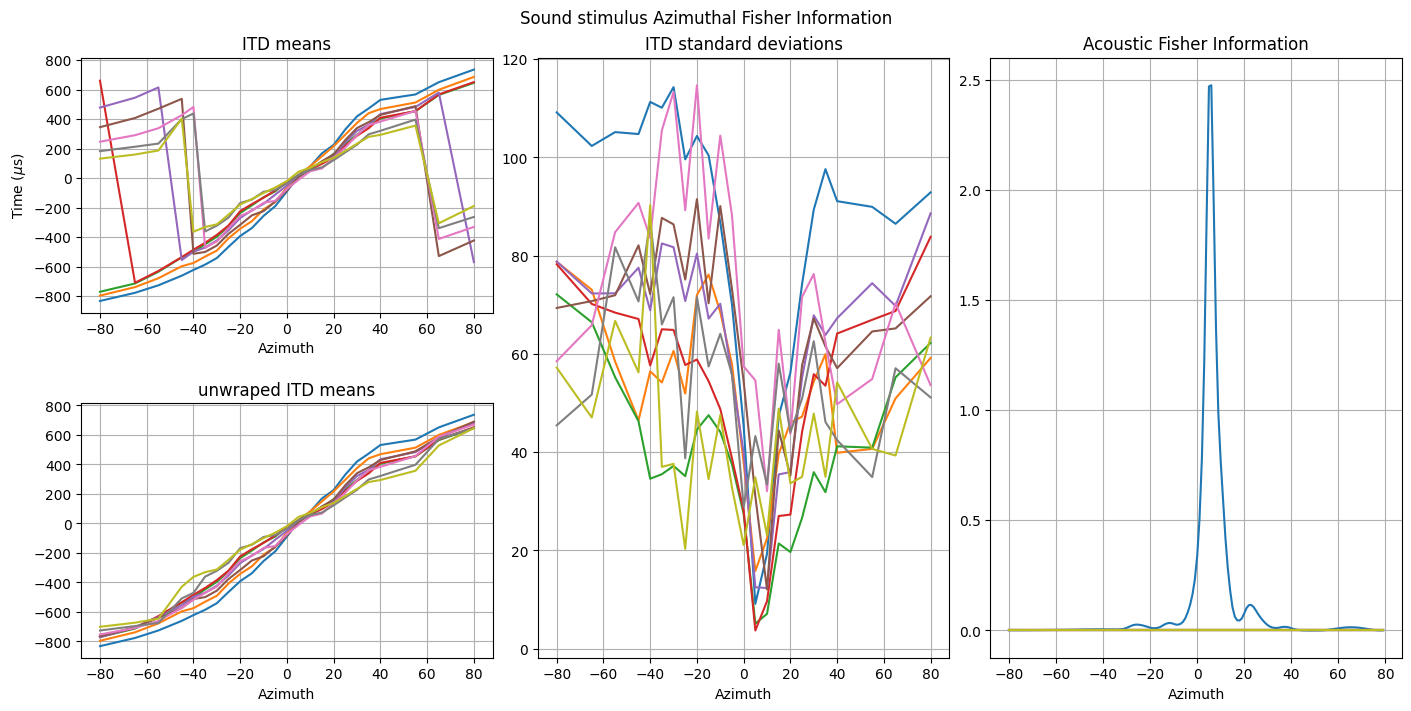

In [26]:

##################################################
#            Download CIPIC Database             #
##################################################
print('Setting HRTF DB')

download_cipic()

cipic_db = load_cipic('./hrir_final.mat')

hrir_l = np.squeeze(cipic_db['hrir_l'][:, 9, :])
hrir_r = np.squeeze(cipic_db['hrir_r'][:, 9, :])

##################################################
#              Cochlear Filter                   #
##################################################
print('Applying Cochlear Filter -- Extracting ITD means')

Sf = 44100 #sampling frequency
trim = int(.25*Sf)

sound = np.squeeze(2*(np.random.rand(1,4*Sf)-0.5), axis=0)

freqs = np.arange(400, 1251, 100)#np.arange(400, 1250, 25)#np.arange(0, 1501, 30)[1:] #np.arange(400, 1250, 100)
azims = np.concatenate(([-80, -65, -55], np.arange(-45, 45, 5), [55, 65, 80]))

ipd_means = np.zeros((len(azims), len(freqs)))
ipd_stds = np.zeros_like(ipd_means)

itd_means = np.zeros_like(ipd_means)
itd_stds = np.zeros_like(ipd_means)

for i, az in tqdm(enumerate(azims)):
    convolved_l = Sound(convolve(sound, hrir_l[i]), samplerate=Sf*Hz)
    convolved_r = Sound(convolve(sound, hrir_r[i]), samplerate=Sf*Hz)

    cochlear_l = Gammatone(convolved_l, freqs).process()  #TODO: ver como fazer estéreo direto (Tile/Join)
    cochlear_r = Gammatone(convolved_r, freqs).process()

    for cl, cr, j in zip(cochlear_l.T, cochlear_r.T, range(len(freqs))):  # iterate over cochelar filter center freqs
        transformed = hilbert(np.stack((cl, cr)), axis=1)

        ipd = wrapToPi(np.diff(np.angle(transformed), axis=0))[0, :]
        ipd = ipd[trim:-trim]

        ipd_mean = circmean(ipd, high=np.pi, low=-np.pi)
        ipd_std = circstd(ipd, high=np.pi, low=-np.pi)

        ipd_means[i,j] = ipd_mean
        ipd_stds[i,j] = ipd_std

        itd_means[i,j] = ipd2itd(ipd_mean, freqs[j])
        itd_stds[i,j] = ipd2itd(ipd_std, freqs[j])

itd_means_unwp = np.zeros((len(azims), len(freqs)))

for i in range(len(freqs)):
  if(np.allclose(np.unwrap(ipd_means[:, i], period=np.pi*2), ipd_means[:, i])):
    itd_means_unwp[:, i] = ipd2itd(np.unwrap(ipd_means[:, i], period=np.pi*(2)), freqs[i])*1e6
  else:
    itd_means_unwp[:, i] = ipd2itd(np.unwrap(ipd_means[:, i]-(2*np.pi), period=np.pi*(2)), freqs[i])*1e6

#for i in range(3):
#  itd_means_unwp[:, i] = ipd2itd(np.unwrap(ipd_means[:, i], period=np.pi*(2)), freqs[i])*1e6

#for i in range(3, len(freqs)):
#  itd_means_unwp[:, i] = ipd2itd(np.unwrap(ipd_means[:, i]-(2*np.pi), period=np.pi*(2)), freqs[i])*1e6


##################################################
#            Acoustic Information                #
##################################################
print('Calculating Acoustic Fisher Information')

azimuths = np.arange(-80, 80, 1)

fisher_info = np.zeros((len(azimuths), len(freqs)))
fisher_info_ipd = np.zeros_like(fisher_info, dtype=[('IPD', np.float64), ('fi', np.float64)])

for i in tqdm(range(1)):
  #fitar media
  mean_fit, _, _, msg1 = interpolate.splrep(azims, itd_means_unwp[:, i], s=len(azims), full_output=True)

  #trocar azimute -> ITD -> IPD
  #IPD = mean_fit(azimutes)*2*np.pi*freqs[i]
  ipd = interpolate.BSpline(*mean_fit)(azimuths)*2*np.pi*freqs[i]*1e-6
  fisher_info_ipd['IPD'][:, i] = ipd#wrapToPi(ipd)

  #derivada da media
  dmean = interpolate.splev(azimuths, mean_fit, der=1)

  #fitar desvio padrao
  std_fit, _, _, msg2 = interpolate.splrep(azims, itd_stds[:, i]*1e6, s=len(azims), full_output=True)
  stds = interpolate.BSpline(*std_fit)(azimuths)
  #derivada desvio padrao
  dstd = interpolate.splev(azimuths, std_fit, der=1)

  #fisher information = (derivada da media/desvio padrao)^2 + 2*(derivada do desvio/desvio padrao)^2
  fisher_info[:, i] = np.power(dmean/stds, 2) + (2*np.power(dstd/stds, 2))

  fisher_info_ipd['fi'][:, i] = fisher_info[:, i]
  #fisher_info_ipd[:, i] = [(ipd, fi) for ipd, fi in zip(IPD, np.sqrt(fisher_info[:, i]))]

plotAcousticFI(azims, azimuths, freqs, itd_means, itd_means_unwp, itd_stds, fisher_info)

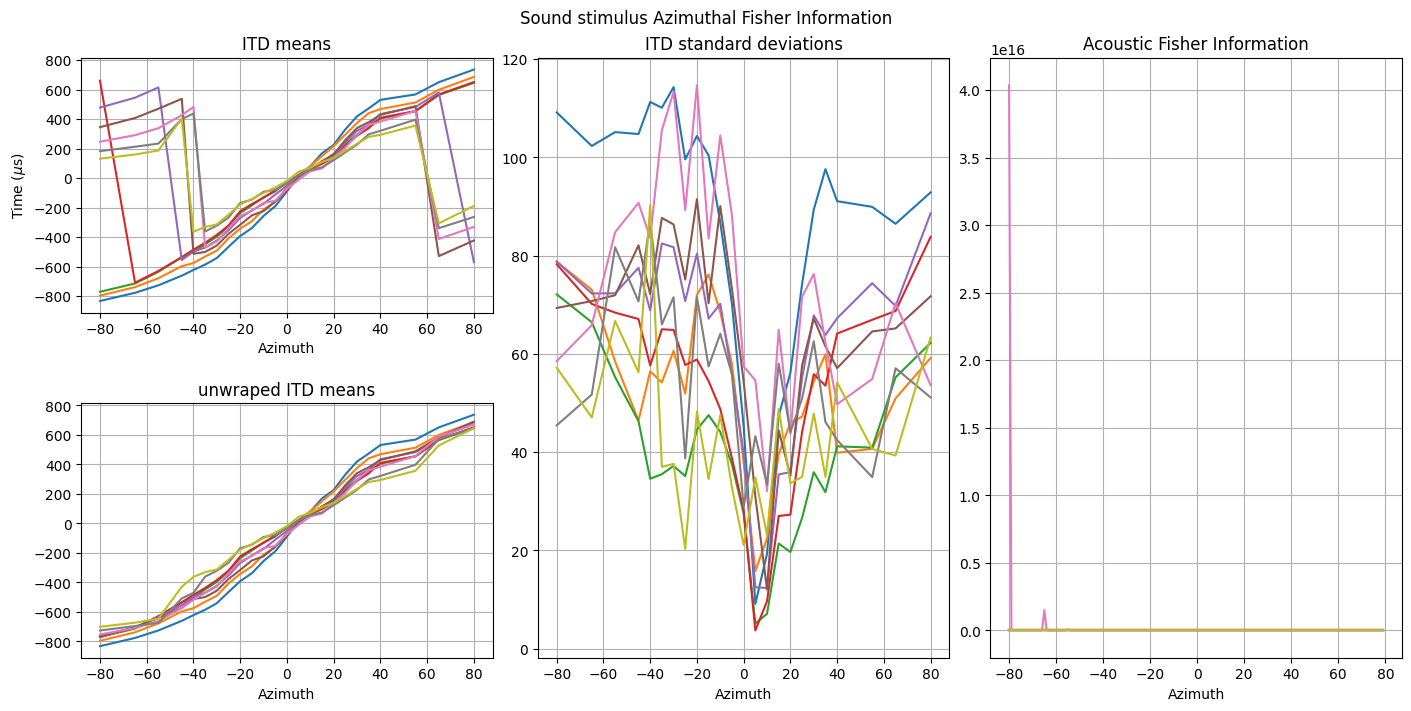

In [82]:
plotAcousticFI(azims, azimuths, freqs, itd_means, itd_means_unwp, itd_stds, fisher_info)

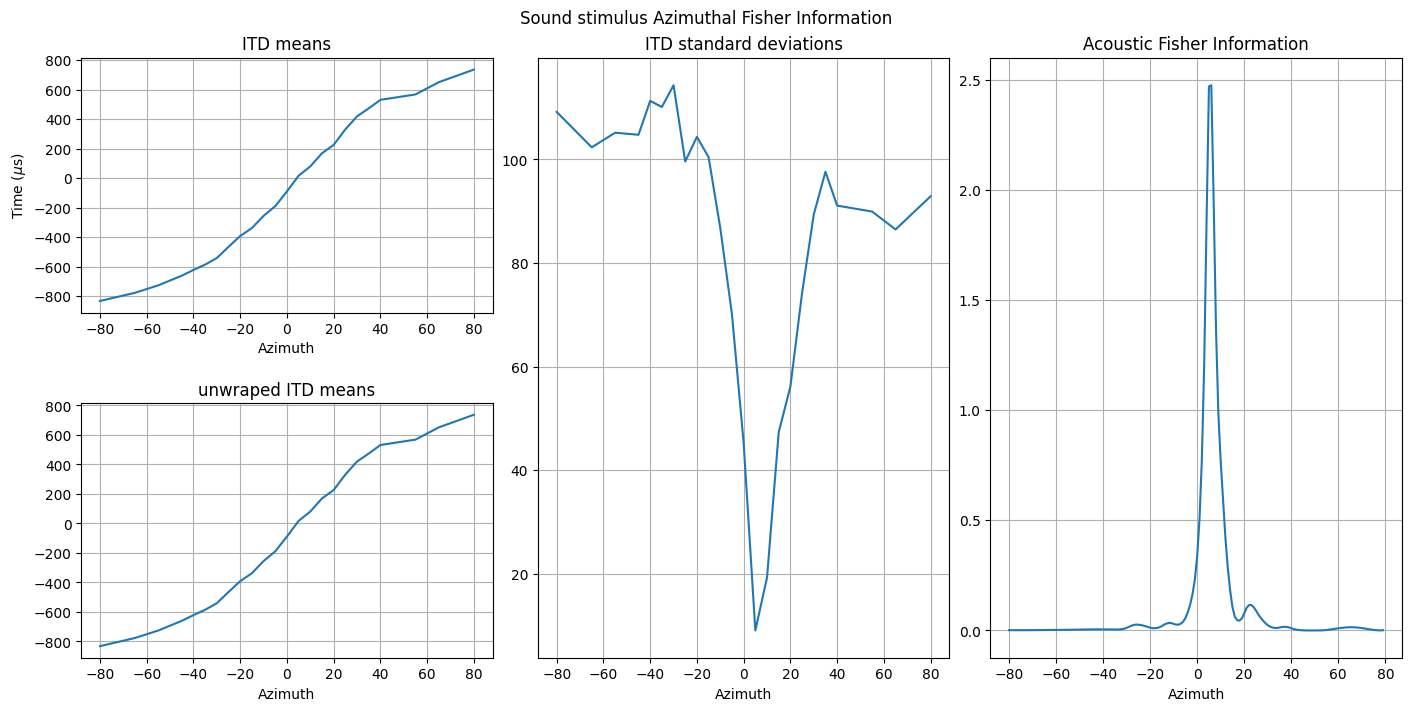

In [87]:
plotAcousticFI(azims, azimuths, [8], itd_means, itd_means_unwp, itd_stds, fisher_info)

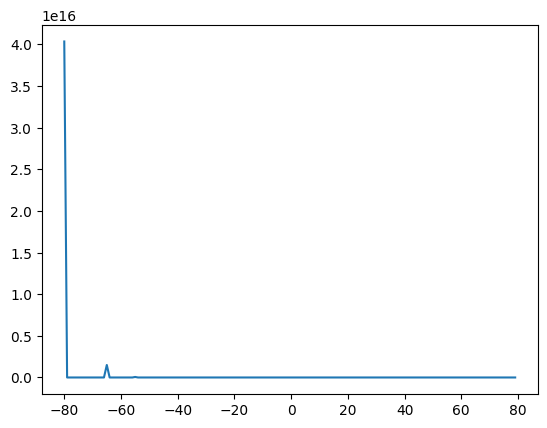

In [88]:
plt.plot(azimuths, fisher_info[:, 6], '-')

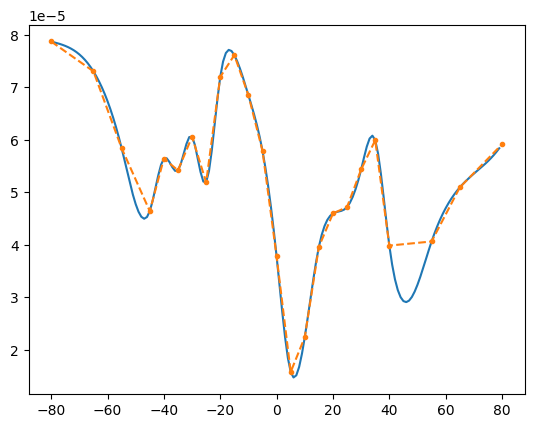

In [104]:

#fitar desvio padrao
#std_fit, _, _, msg2 = interpolate.splrep(azims, itd_stds[:, 1], s=len(azims), k=5, full_output=True)
#stds = interpolate.BSpline(*std_fit)(azimuths)
std_fit = interpolate.CubicSpline(azims, itd_stds[:, 1])
#stds = interpolate.CubicSpline()
plt.plot(azimuths, std_fit(azimuths))
plt.plot(azims, itd_stds[:, 1], '.--')

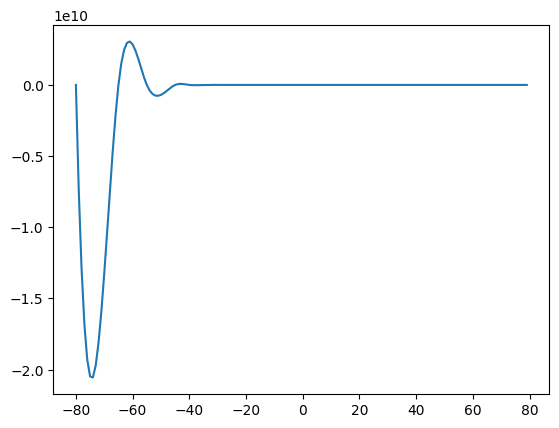

In [78]:
for i in [6]:#qdm(range(len(freqs))):
  mean_fit, _, _, msg1 = interpolate.splrep(azims, itd_means_unwp[:, i], s=len(azims), full_output=True)

  #trocar azimute -> ITD -> IPD
  #IPD = mean_fit(azimutes)*2*np.pi*freqs[i]
  ipd = interpolate.BSpline(*mean_fit)(azimuths)*2*np.pi*freqs[i]*1e-6
  fisher_info_ipd['IPD'][:, i] = ipd#wrapToPi(ipd)

  #plt.plot(azimuths, ipd)

  #derivada da media
  dmean = interpolate.splev(azimuths, mean_fit, der=1)

  #fitar desvio padrao
  std_fit, _, _, msg2 = interpolate.splrep(azims, itd_stds[:, i]*1e6, s=len(azims), full_output=True)
  stds = interpolate.BSpline(*std_fit)(azimuths)
  #derivada desvio padrao
  dstd = interpolate.splev(azimuths, std_fit, der=1)

  plt.plot(azimuths, stds)

  #fisher information = (derivada da media/desvio padrao)^2 + 2*(derivada do desvio/desvio padrao)^2
  fisher_info[:, i] = np.power(dmean/stds, 2) + (2*np.power(dstd/stds, 2))

  fisher_info_ipd['fi'][:, i] = fisher_info[:, i]
  #fisher_info_ipd[:, i] = [(ipd, fi) for ipd, fi in zip(IPD, np.sqrt(fisher_info[:, i]))]


  #plt.plot(interpolate.BSpline(*mean_fit)(azimuths) ,fisher_info_ipd['fi'][:, i], '.--')
  #plt.plot(azimuths, fisher_info_ipd['fi'][:, i], '.--')
  #plt.plot(azimuths, interpolate.BSpline(*mean_fit)(azimuths))

#plotAcousticFI(azims, azimuths, freqs, itd_means, itd_means_unwp, itd_stds, fisher_info)

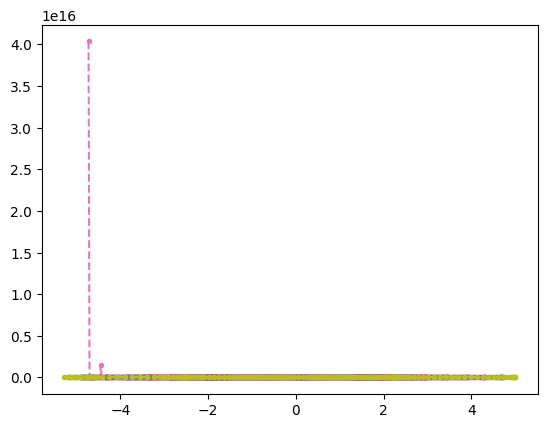

In [72]:
for i in range(len(freqs)):
  plt.plot(fisher_info_ipd['IPD'][:, i], fisher_info_ipd['fi'][:, i], '.--', label=freqs[i])
plt.show()

In [73]:
phi_optimal = []
nneurons = 50 #200 #50

rand =  np.random.rand(nneurons)
phi_rand = (-np.pi * rand) + np.pi * (1 - rand)

F_acoustic = np.sqrt(fisher_info_ipd['fi'].transpose())
IPDs = fisher_info_ipd['IPD'].transpose()

phi_optimal = None

start_time = pytime()

res = optimize_acoustic(F_acoustic[7], phi_rand, IPDs[7])

In [69]:
freqs

array([ 400,  500,  600,  700,  800,  900, 1000, 1100, 1200])

(array([3., 1., 3., 1., 0., 0., 0., 1., 0., 1.]),
 array([-1.98598887, -0.93009485,  0.12579916,  1.18169317,  2.23758719,
         3.2934812 ,  4.34937521,  5.40526923,  6.46116324,  7.51705725,
         8.57295127]),
 <BarContainer object of 10 artists>)

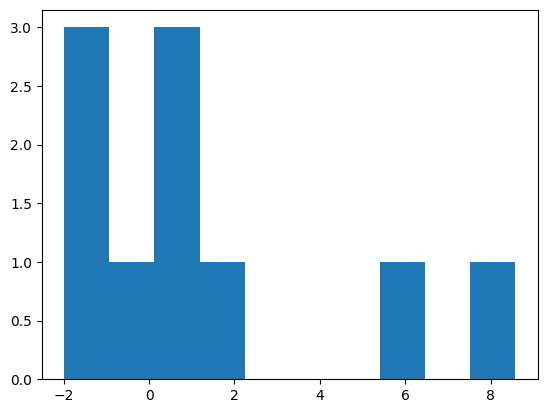

In [58]:
plt.hist(res)

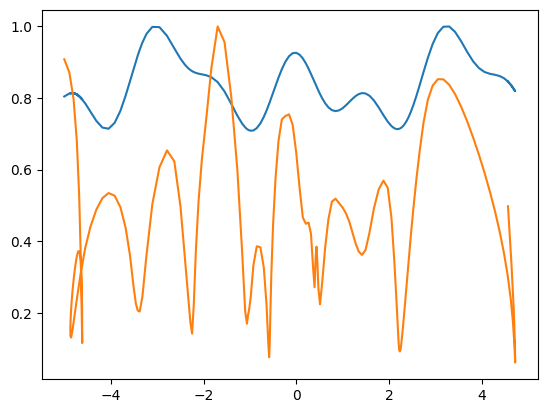

In [74]:
i=7
plt.plot(IPDs[i], F_neural(IPDs[i], res, 1, 1)/np.max(F_neural(IPDs[i], res, 1, 1)))
plt.plot(IPDs[i], F_acoustic[i]/np.max(F_acoustic[i]))

In [54]:
pearsonr(np.arange(3), np.arange(3)).statistic

0.9999999999999998